# Topic trends with citation tree generation

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct

import nlp_utils as nu

DATASET_DIR = r'C:\Users\aspit\Git\NLP-Semantic\datasets'
db_path = os.path.join(DATASET_DIR, 'soc.db')
con = sqlite3.connect(db_path)

#Words common in all literature
gen_lit_tw = pd.read_csv('data/gen_literature_top_words.csv',index_col=0)
gen_lit_remove = gen_lit_tw[0:130].index.values


First a set of papers is loaded in the that represent a field of interest, in this case a set of broad review articles about energy storage

In [2]:

all_dois = pd.read_csv('data/tech_doi.csv')
input_dois = all_dois['general'].dropna()

df = nu.io.load_df_semantic(con, input_dois, cust_idx_name='doi')

for doi in input_dois:
    if doi not in df['doi'].values:
        print("Could not find doi: " + str(doi))
df['title'].values

array(['A comprehensive evaluation of energy storage options for better sustainability',
       'Energy storage systems—Characteristics and comparisons',
       'Classification and assessment of energy storage systems',
       'Energy storage for electricity generation and related processes: Technologies appraisal and grid scale applications',
       'Assessment of energy storage technologies: A review',
       'A review of energy storage types, applications and recent developments',
       'Correction: Review of electrical energy storage technologies, materials and systems: challenges and prospects for large-scale grid storage',
       'Comparative Review of Energy Storage Systems, Their Roles, and Impacts on Future Power Systems',
       'A Numerical and Graphical Review of Energy Storage Technologies',
       'A Review of Energy Storage Technologies’ Application Potentials in Renewable Energy Sources Grid Integration'],
      dtype=object)

## Literature community genreation
We genreate a corpus from these seed papers by building a citation graph from the seed papers. This is unbiased compared to searching for papers containing search terms like 'energy storage' as not all relevant papers might have that phrase. 

1. A citation graph of all articles cited by or citing the seed articles is generated
2. the graph nodes are sorted by the fractional connection of connections of each paper where the fractional connection is defined by `(total connected edges)/(total references+citaitons)`. Then the graph is trimmed 1) to remove papers with less than `frac_keep_factor*(average connected fraction)` and then 2) to only have a given maximumnumber of connections (`n_initial_trim`). In this way the graph is trimmed to remove papers that have a small fraction of their references/citations in the overall literatrue community. 

This process is repeated a given number of iterations

In [3]:
df_com = nu.citation.build_citation_community(df, con, n_iter=5, frac_keep_factor=0.5, n_trim=10000)


---Step 0---
Before graph generation: 10
After Graph Generation: 3201
---Step 1---
Before graph generation: 2305
After Graph Generation: 277983
Size after database checking: 8247
Average connected fraction: 0.334
discading nodes with fewer than 0.167 fraction connected edges
After trimming edges: 2806
---Step 2---
Before graph generation: 2821
After Graph Generation: 282105
Size after database checking: 8277
Average connected fraction: 0.388
discading nodes with fewer than 0.194 fraction connected edges
After trimming edges: 3048
---Step 3---
Before graph generation: 3069
After Graph Generation: 284159
Size after database checking: 8209
Average connected fraction: 0.419
discading nodes with fewer than 0.209 fraction connected edges
After trimming edges: 3209
---Step 4---
Before graph generation: 3230
After Graph Generation: 285757
Size after database checking: 8225
Average connected fraction: 0.434
discading nodes with fewer than 0.217 fraction connected edges
After trimming edges: 330

## Topic model generation

In [4]:
docs = df_com['title'] + ' ' + df_com['paperAbstract']
texts = docs.apply(str.split)

corex_anchors = []
# corex_anchors = [['fuel_cel', 'electrolyz'], ['pump_thermal', 'heat_pump'], 'li_ion']
fixed_bigrams = nu.corex_utils.anchors_to_fixed_bigrams(corex_anchors)

pipeline = Pipeline([
    ('text_norm', nu.text_process.TextNormalizer(post_stopwords=gen_lit_remove)),
    ('bigram', nu.gensim_utils.Gensim_Bigram_Transformer(bigram_kwargs={'threshold':20, 'min_count':10}, fixed_bigrams=fixed_bigrams)),
    ('vectorizer', CountVectorizer(max_features=None, min_df=2, max_df = 0.9, tokenizer= lambda x: x, preprocessor=lambda x:x, input='content')), #https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer
])

X = pipeline.fit_transform(texts)
feature_names = pipeline['vectorizer'].get_feature_names()

topic_model = ct.Corex(n_hidden=30, seed=42)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X, words=feature_names, docs=docs.index, anchors=corex_anchors, anchor_strength=5)

s_topic_words = nu.corex_utils.get_s_topic_words(topic_model, 10)
df_doc_topic_probs = pd.DataFrame(topic_model.p_y_given_x, index=df_com.index , columns=s_topic_words.index)
df_topicsyear = nu.common.calc_topics_year(df_doc_topic_probs, df_com['year'], norm_each_topic=False)

## Trends and top words for each topic

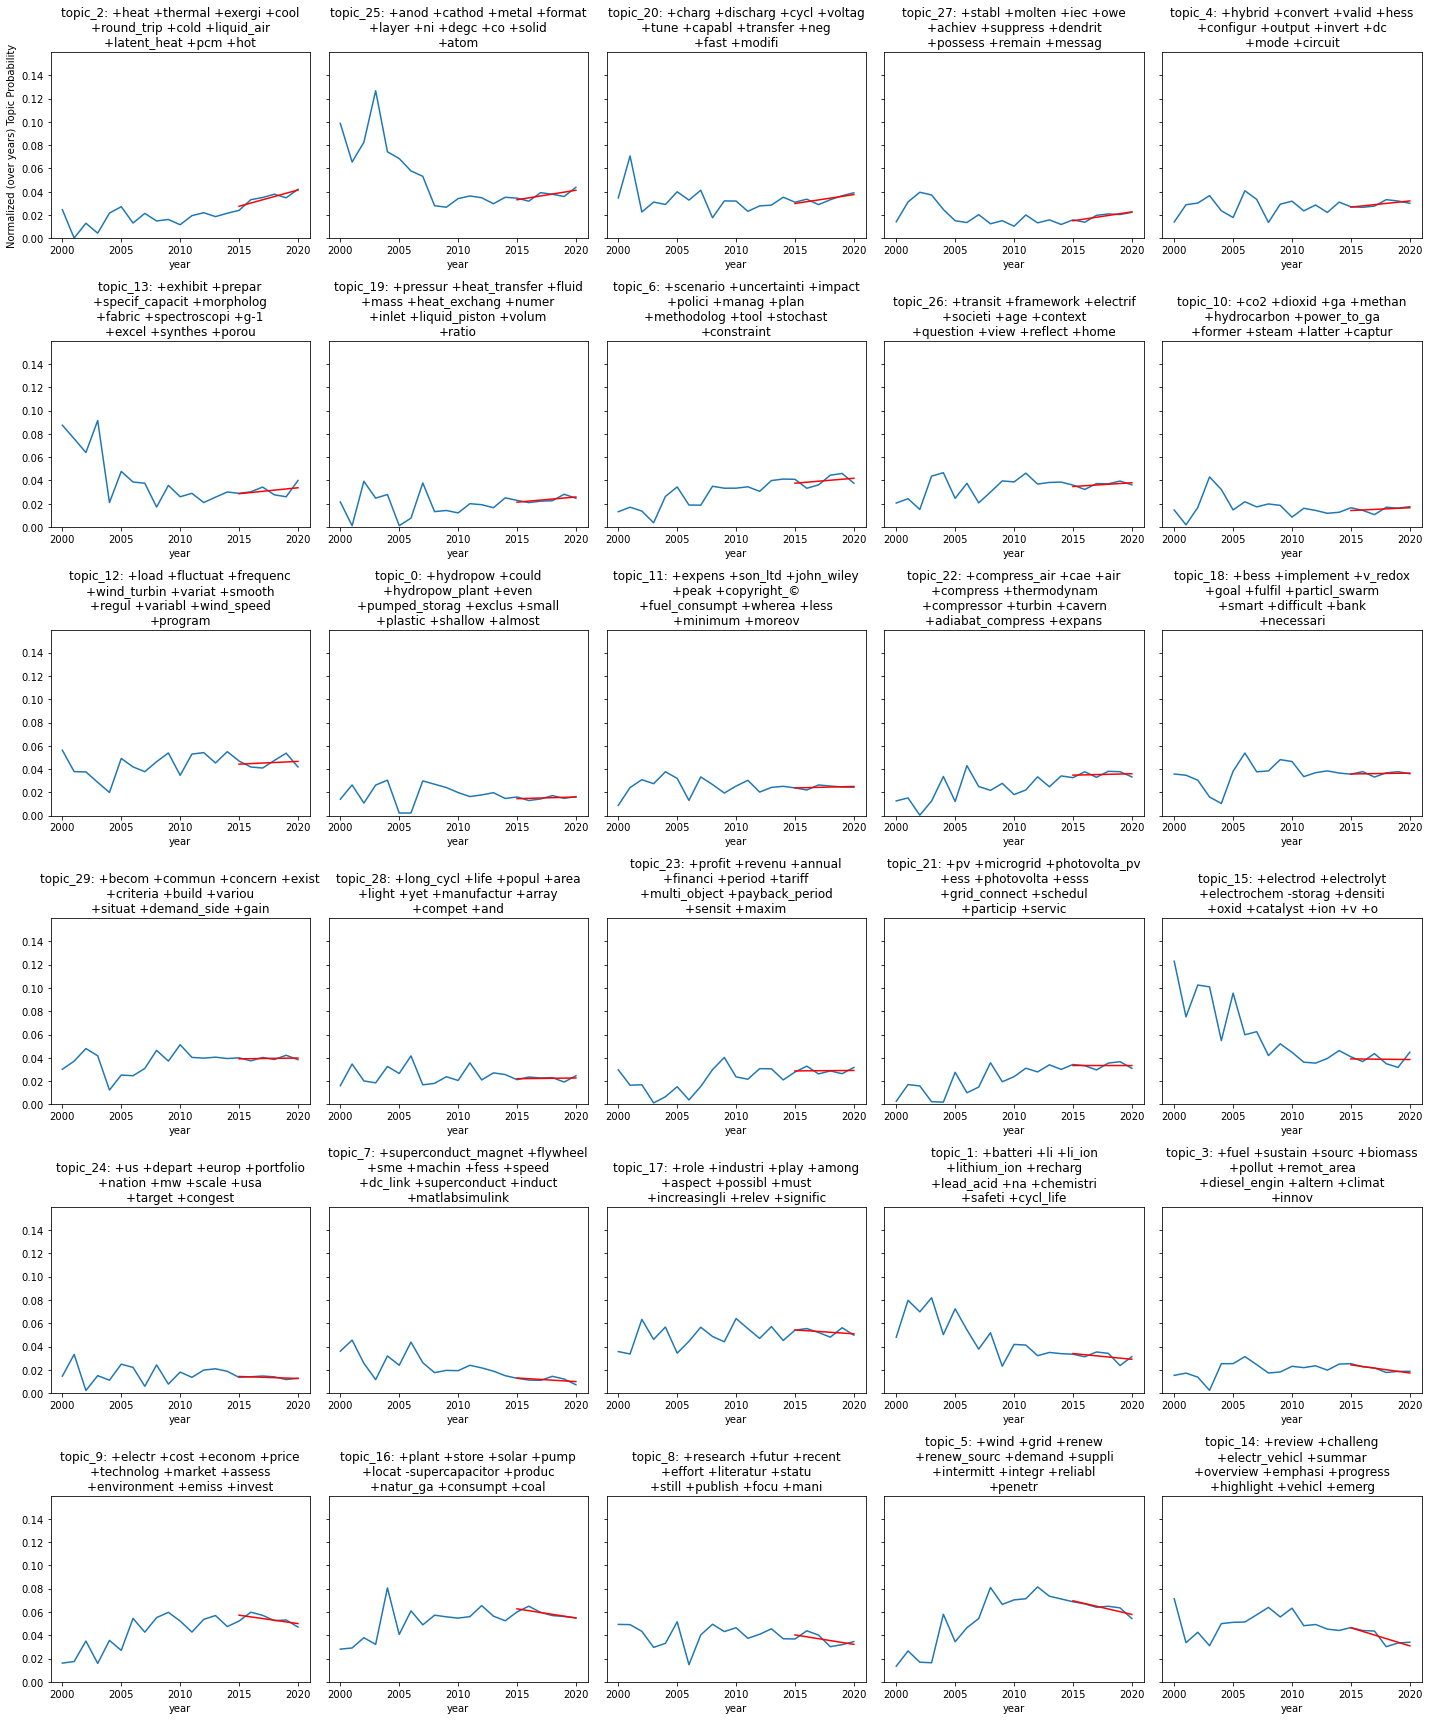

In [5]:
year_range_fit = slice(2015,2020)
year_range_plot = slice(2000,2020)

nu.plot.top_slopes_plot(df_topicsyear.loc[year_range_plot], s_topic_words, year_range_fit, n_plots=30)

In [6]:

topic_num = 2
topic_str = 'topic_' + str(topic_num)
top_docs = topic_model.get_top_docs()[topic_num]

print(topic_str)
print(s_topic_words[topic_str])
print("-"+"\n-".join(df_com['title'].loc[[t[0] for t in top_docs]]))


topic_2
+heat +thermal +exergi +cool +round_trip +cold +liquid_air +latent_heat +pcm +hot 
-Liquid air energy storage flexibly coupled with LNG regasification for improving air liquefaction
-Liquid Air Energy Storage (LAES) as a large-scale storage technology for renewable energy integration - A review of investigation studies and near perspectives of LAES
-Fatty acid/metal ion composite as thermal energy storage materials
-Exergy-Based and Economic Evaluation of Liquefaction Processes for Cryogenics Energy Storage
-Integration of cryogenic energy storage and cryogenic organic cycle to geothermal power plants
-Energy and exergy analysis of wind farm integrated with compressed air energy storage using multi-stage phase change material
-Liquid Air Energy Storage performance enhancement by means of Organic Rankine Cycle and Absorption Chiller
-Fatty Acids as Phase Change Materials (PCMs) for Thermal Energy Storage: A Review
-Thermo-economic optimization of a combined cooling, heating and 

# Anchored word topic modeling 

We can anchor some topics to words of interest. 

In [19]:
docs = df_com['title'] + ' ' + df_com['paperAbstract']
texts = docs.apply(str.split)

corex_anchors = [['orr', 'o_reduct'], ['pump_thermal', 'heat_pump'], 'li_ion', 'liquid_metal']
fixed_bigrams = nu.corex_utils.anchors_to_fixed_bigrams(corex_anchors)

pipeline = Pipeline([
    ('text_norm', nu.text_process.TextNormalizer(post_stopwords=gen_lit_remove)),
    ('bigram', nu.gensim_utils.Gensim_Bigram_Transformer(bigram_kwargs={'threshold':20, 'min_count':10}, fixed_bigrams=fixed_bigrams)),
    ('vectorizer', CountVectorizer(max_features=None, min_df=2, max_df = 0.9, tokenizer= lambda x: x, preprocessor=lambda x:x, input='content')), #https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer
])

X = pipeline.fit_transform(texts)
feature_names = pipeline['vectorizer'].get_feature_names()

topic_model = ct.Corex(n_hidden=30, seed=42)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X, words=feature_names, docs=docs.index, anchors=corex_anchors, anchor_strength=5)

s_topic_words = nu.corex_utils.get_s_topic_words(topic_model, 10)
df_doc_topic_probs = pd.DataFrame(topic_model.p_y_given_x, index=df_com.index , columns=s_topic_words.index)
df_topicsyear = nu.common.calc_topics_year(df_doc_topic_probs, df_com['year'], norm_each_topic=False)

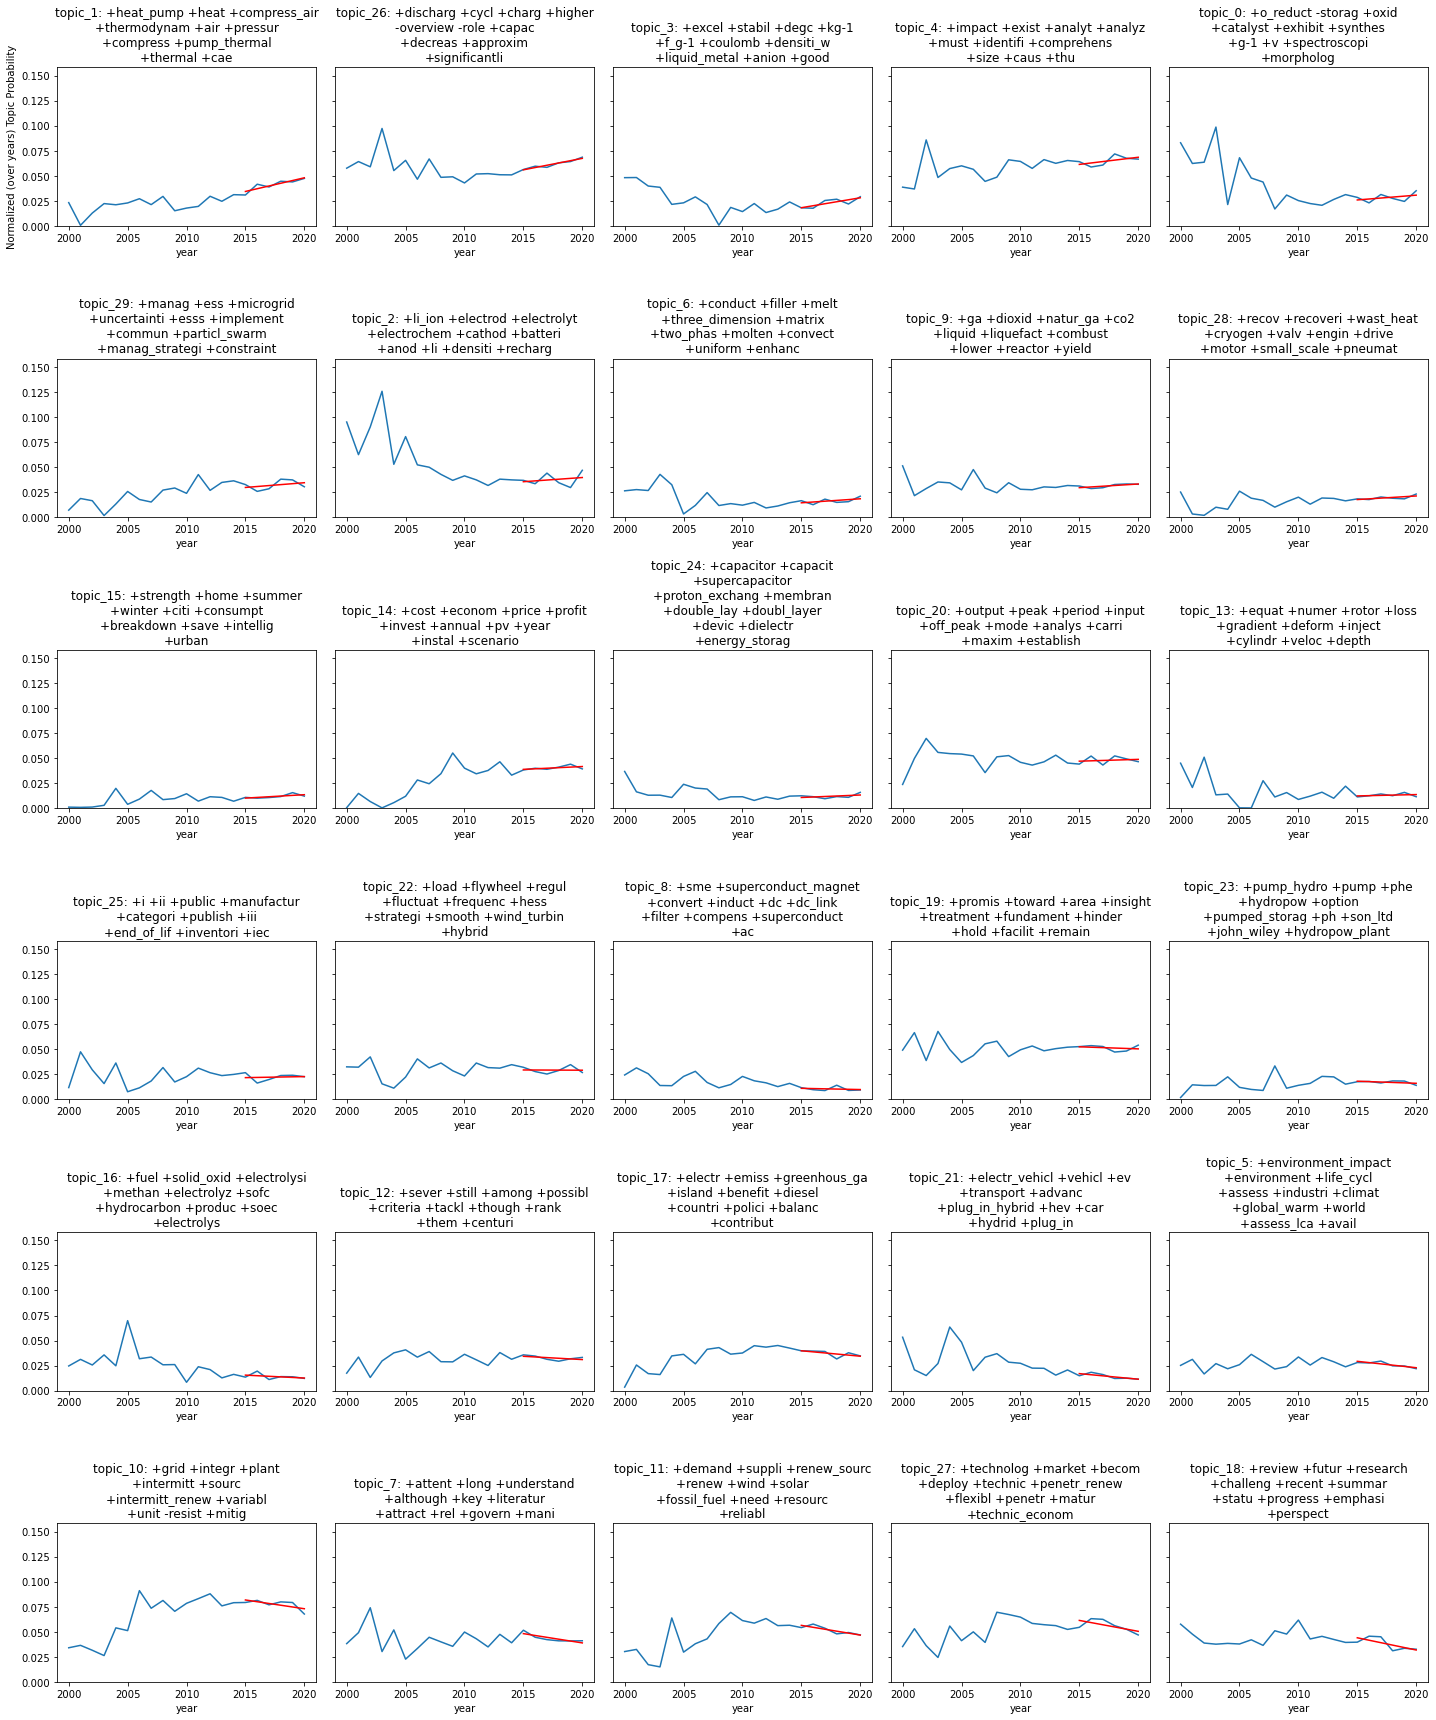

In [20]:
year_range_fit = slice(2015,2020)
year_range_plot = slice(2000,2020)

nu.plot.top_slopes_plot(df_topicsyear.loc[year_range_plot], s_topic_words, year_range_fit, n_plots=30)

In [32]:

topic_num = 3
topic_str = 'topic_' + str(topic_num)
top_docs = topic_model.get_top_docs()[topic_num]

print(topic_str)
print(s_topic_words[topic_str])
print("-"+"\n-".join(df_com['title'].loc[[t[0] for t in top_docs]]))


topic_3
+excel +stabil +degc +kg-1 +f_g-1 +coulomb +densiti_w +liquid_metal +anion +good 
-High performance sodium-sulfur batteries at low temperature enabled by superior molten Na wettability.
-Anchoring Mo single atoms/clusters and N on edge-rich nanoporous holey graphene as bifunctional air electrode in Zn−air batteries
-W18O49 nanowires-graphene nanocomposite for asymmetric supercapacitors employing AlCl3 aqueous electrolyte
-Electrochemical and surface studies of zinc in alkaline solutions containing organic corrosion inhibitors
-Faradaically selective membrane for liquid metal displacement batteries
-The crossover behavior of bromine species in the metal-free flow battery
-Scaling the water cluster size of Nafion membranes for a high performance Zn/Br redox flow battery
-Out‐of‐Cell Oxygen Diffusivity Evaluation in Lithium–Air Batteries
-Insights into the interfacial nanostructuring of NiCo2S4 and their electrochemical activity for ultra-high capacity all-solid-state flexible asy

Build a research community from one of the topics

In this case about the pumed thermal energy storage. 

Going drop a larger fraction of the papers each iteration such that the community is more focused. 

In [26]:

df_subset = df_com.loc[[t[0] for t in topic_model.get_top_docs(topic=1)]]

df_subset['title'].values


array(['Multi-criteria investigation of a pumped thermal electricity storage (PTES) system with thermal integration and sensible heat storage',
       'Performance Improvement of a Double Pipe Heat Exchanger Proposed in a Small-Scale CAES System: An Innovative Design',
       'Thermodynamic analysis of a High Temperature Pumped Thermal Electricity Storage (HT-PTES) integrated with a parallel organic Rankine cycle (ORC)',
       'Thermodynamic analysis of Liquid Air Energy Storage integrated with a serial system of Organic Rankine and Absorption Refrigeration Cycles driven by compression heat',
       'Liquid piston compression efficiency with droplet heat transfer',
       'Justification of CO2 as the working fluid for a compressed gas energy storage system: A thermodynamic and economic study',
       'Thermodynamic analysis of pumped thermal electricity storage',
       'Study of effect of heat transfer in an air storage vessel on performance of a pumped hydro compressed air energy st

In [33]:
df_com = nu.citation.build_citation_community(df_subset, con, n_iter=5, frac_keep_factor=0.3, n_trim=1000)


---Step 0---
Before graph generation: 10
After Graph Generation: 503
---Step 1---
Before graph generation: 395
After Graph Generation: 36314
Size after database checking: 840
Average connected fraction: 0.554
discading nodes with fewer than 0.166 fraction connected edges
After trimming edges: 573
---Step 2---
Before graph generation: 575
After Graph Generation: 37539
Size after database checking: 849
Average connected fraction: 0.725
discading nodes with fewer than 0.218 fraction connected edges
After trimming edges: 648
---Step 3---
Before graph generation: 650
After Graph Generation: 38288
Size after database checking: 849
Average connected fraction: 0.798
discading nodes with fewer than 0.239 fraction connected edges
After trimming edges: 687
---Step 4---
Before graph generation: 690
After Graph Generation: 38746
Size after database checking: 853
Average connected fraction: 0.828
discading nodes with fewer than 0.248 fraction connected edges
After trimming edges: 699


In [35]:
docs = df_com['title'] + ' ' + df_com['paperAbstract']
texts = docs.apply(str.split)

# corex_anchors = [['orr', 'o_reduct'], ['pump_thermal', 'heat_pump'], 'li_ion', 'liquid_metal']
corex_anchors = []
fixed_bigrams = nu.corex_utils.anchors_to_fixed_bigrams(corex_anchors)

pipeline = Pipeline([
    ('text_norm', nu.text_process.TextNormalizer(post_stopwords=gen_lit_remove)),
    ('bigram', nu.gensim_utils.Gensim_Bigram_Transformer(bigram_kwargs={'threshold':20, 'min_count':10}, fixed_bigrams=fixed_bigrams)),
    ('vectorizer', CountVectorizer(max_features=None, min_df=2, max_df = 0.9, tokenizer= lambda x: x, preprocessor=lambda x:x, input='content')), #https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer
])

X = pipeline.fit_transform(texts)
feature_names = pipeline['vectorizer'].get_feature_names()

topic_model = ct.Corex(n_hidden=10, seed=42)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X, words=feature_names, docs=docs.index, anchors=corex_anchors, anchor_strength=5)

s_topic_words = nu.corex_utils.get_s_topic_words(topic_model, 10)
df_doc_topic_probs = pd.DataFrame(topic_model.p_y_given_x, index=df_com.index , columns=s_topic_words.index)
df_topicsyear = nu.common.calc_topics_year(df_doc_topic_probs, df_com['year'], norm_each_topic=False)

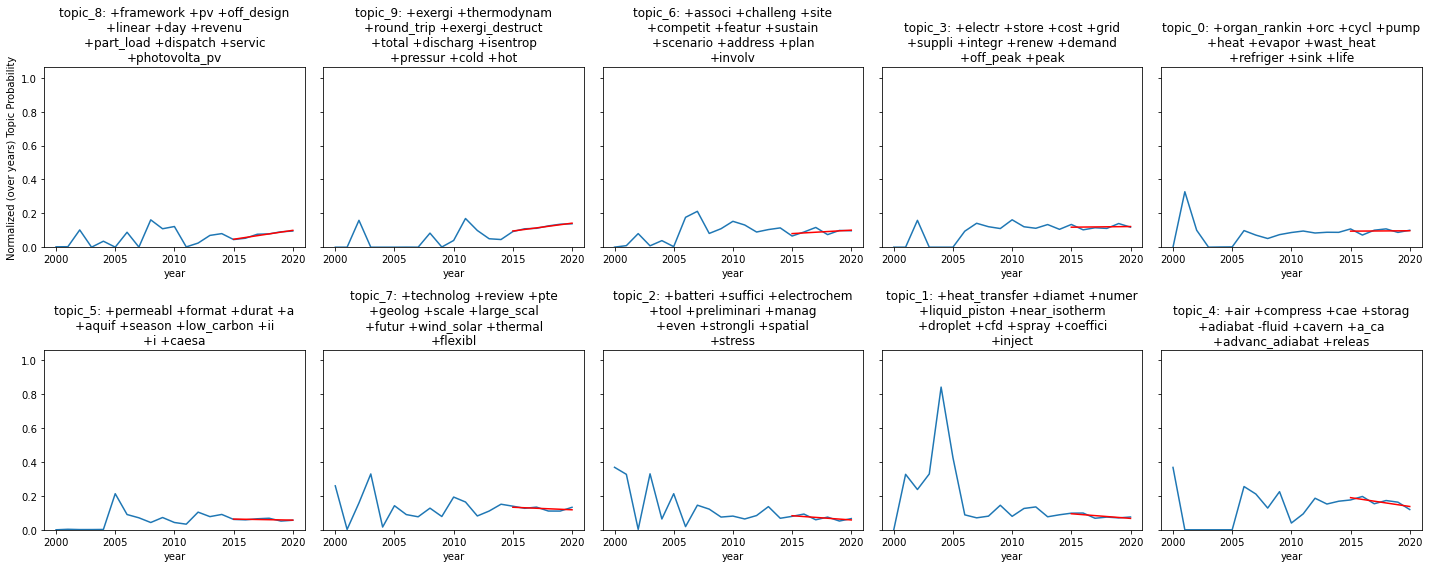

In [36]:
year_range_fit = slice(2015,2020)
year_range_plot = slice(2000,2020)

nu.plot.top_slopes_plot(df_topicsyear.loc[year_range_plot], s_topic_words, year_range_fit, n_plots=topic_model.n_hidden)

# custom thermomechanical article base

Alternatively we can start with a series of thermomechanical review articles 

In [37]:

all_dois = pd.read_csv('data/tech_doi.csv')
input_dois = all_dois['thermomechanical'].dropna()

df = nu.io.load_df_semantic(con, input_dois, cust_idx_name='doi')

for doi in input_dois:
    if doi not in df['doi'].values:
        print("Could not find doi: " + str(doi))
df['title'].values

Could not find doi: 10.17863/CAM.37776


array(['A review on compressed air energy storage: Basic principles, past milestones and recent developments',
       'Thermo-mechanical concepts for bulk energy storage',
       'Pumped Thermal Electricity Storage: A technology overview',
       'Pumped thermal grid storage with heat exchange',
       'Progress and prospects of thermo-mechanical energy storage—a critical review',
       'A comparative study of the Adiabatic Compressed Air Energy Storage (A-CAES) and Pumped Thermal Energy Storage (PTES) systems'],
      dtype=object)

In [38]:
df_com = nu.citation.build_citation_community(df, con, n_iter=5, frac_keep_factor=0.5, n_trim=10000)


---Step 0---
Before graph generation: 6
After Graph Generation: 804
---Step 1---
Before graph generation: 592
After Graph Generation: 44233
Size after database checking: 7541
Average connected fraction: 0.133
discading nodes with fewer than 0.066 fraction connected edges
After trimming edges: 2370
---Step 2---
Before graph generation: 2370
After Graph Generation: 66965
Size after database checking: 7777
Average connected fraction: 0.349
discading nodes with fewer than 0.174 fraction connected edges
After trimming edges: 2637
---Step 3---
Before graph generation: 2637
After Graph Generation: 69210
Size after database checking: 7719
Average connected fraction: 0.382
discading nodes with fewer than 0.191 fraction connected edges
After trimming edges: 2758
---Step 4---
Before graph generation: 2758
After Graph Generation: 70127
Size after database checking: 7749
Average connected fraction: 0.395
discading nodes with fewer than 0.198 fraction connected edges
After trimming edges: 2851


In [39]:
docs = df_com['title'] + ' ' + df_com['paperAbstract']
texts = docs.apply(str.split)

corex_anchors = []
# corex_anchors = [['fuel_cel', 'electrolyz'], ['pump_thermal', 'heat_pump'], 'li_ion']
fixed_bigrams = nu.corex_utils.anchors_to_fixed_bigrams(corex_anchors)

pipeline = Pipeline([
    ('text_norm', nu.text_process.TextNormalizer(post_stopwords=gen_lit_remove)),
    ('bigram', nu.gensim_utils.Gensim_Bigram_Transformer(bigram_kwargs={'threshold':20, 'min_count':10}, fixed_bigrams=fixed_bigrams)),
    ('vectorizer', CountVectorizer(max_features=None, min_df=2, max_df = 0.9, tokenizer= lambda x: x, preprocessor=lambda x:x, input='content')), #https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer
])

X = pipeline.fit_transform(texts)
feature_names = pipeline['vectorizer'].get_feature_names()

topic_model = ct.Corex(n_hidden=10, seed=42)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X, words=feature_names, docs=docs.index, anchors=corex_anchors, anchor_strength=5)

s_topic_words = nu.corex_utils.get_s_topic_words(topic_model, 10)
df_doc_topic_probs = pd.DataFrame(topic_model.p_y_given_x, index=df_com.index , columns=s_topic_words.index)
df_topicsyear = nu.common.calc_topics_year(df_doc_topic_probs, df_com['year'], norm_each_topic=False)

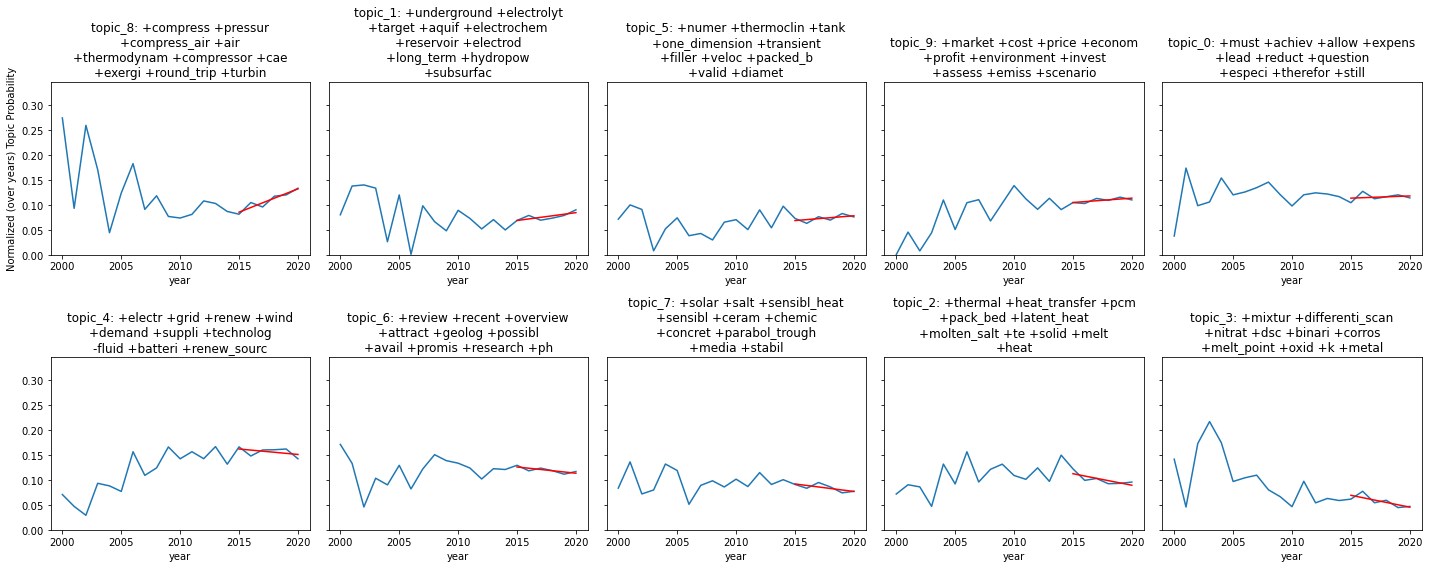

In [40]:
year_range_fit = slice(2015,2020)
year_range_plot = slice(2000,2020)

nu.plot.top_slopes_plot(df_topicsyear.loc[year_range_plot], s_topic_words, year_range_fit, n_plots=30)